Jesse Galef

Columbia University uni: jbg2160

Computational Genomics Spring 2018


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

import Bio
from Bio.Phylo.TreeConstruction import *
import os
from Bio.Seq import Seq
from Bio.SeqIO import FastaIO
from cStringIO import StringIO

from Bio import Align
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord

import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Reshape, Merge
from keras.models import Model
from keras import regularizers
from keras.layers import concatenate, Lambda
from keras.regularizers import Regularizer
from keras.optimizers import Adadelta
import keras.backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, RandomNormal, Ones

from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints


import seaborn as sns

Using TensorFlow backend.


In [2]:
names = [['mouse', 'Mus musculus', 'July 2007', 'mm9'],
['rat', 'Rattus norvegicus', 'Nov 2004', 'rn4'],
['guinea pig', 'Cavia porcellus', 'Oct 2005', 'cavPor2'],
['rabbit', 'Oryctolagus cuniculus', 'May 2005', 'oryCun1'],
['human', 'Homo sapiens', 'Mar 2006', 'hg18'],
['chimpanzee', 'Pan troglodytes', 'Mar 2006', 'panTro2'],
['orangutan', 'Pongo pygmaeus abelii', 'July 2007', 'ponAbe2'],
['rhesus', 'Macaca mulatta', 'Jan 2006', 'rheMac2'],
['marmoset', 'Callithrix jacchus', 'June 2007', 'calJac1'],
['bushbaby', 'Otolemur garnetti', 'Dec 2006', 'otoGar1'],
['tree shrew', 'Tupaia belangeri', 'Dec 2006', 'tupBel1'],
['shrew', 'Sorex araneus', 'June 2006', 'sorAra1'],
['hedgehog', 'Erinaceus europaeus', 'June 2006', 'eriEur1'],
['dog', 'Canis familiaris', 'May 2005', 'canFam2'],
['cat', 'Felis catus', 'Mar 2006', 'felCat3'],
['horse', 'Equus caballus', 'Jan 2007', 'equCab1'],
['cow', 'Bos taurus', 'Aug 2006', 'bosTau3'],
['armadillo', 'Dasypus novemcinctus', 'May 2005', 'dasNov1'],
['elephant', 'Loxodonta africana', 'May 2005', 'loxAfr1'],
['tenrec', 'Echinops telfairi', 'July 2005', 'echTel1'],
['opossum', 'Monodelphis domestica', 'Jan 2006', 'monDom4'],
['platypus', 'Ornithorhychus anatinus', 'Mar 2007', 'ornAna1'],
['chicken', 'Gallus gallus', 'May 2006', 'galGal3'],
['lizard', 'Anolis carolinensis', 'Feb 2007', 'anoCar1'],
['frog', 'Xenopus tropicalis', 'Aug 2005', 'xenTro2'],
['tetraodon', 'Tetraodon nigroviridis', 'Feb 2004', 'tetNig1'],
['fugu', 'Takifugu rubripes', 'Oct 2004', 'fr2'],
['stickleback', 'Gasterosteus aculeatus', 'Feb 2006', 'gasAcu1'],
['medaka', 'Oryzias latipes', 'Apr 2006', 'oryLat1'],
['zebrafish', 'Danio rerio', 'July 2007', 'danRer5']]
nmap = {n[3]: n[0] for n in names}
nSpecies = len(names)
speciesList = nmap.keys()


In [3]:
def sequencesToMatrix(sequences, vocab=['A','C','T','G','-']):
    """
    Passed a list of strings, one-hot encodes them
    with the - for any symbols not in the passed vocab
    
    Returns a matrix sequenceLength x numberOfSequences x sizeOfVocab
    """
    matrix = np.zeros([len(sequences[0]), len(vocab), len(sequences)])
    vmap = {vocab[i]: i for i in range(len(vocab))}
    for i, seq in enumerate(sequences):
        for j, character in enumerate(seq):
            if character not in vmap:
                print character, " replaced by -"
                character = '-'
            whichCharIndex = vmap[character]
            matrix[j,whichCharIndex,i] = 1
    return matrix

In [19]:
# Uncomment this cell if you have and want to use the refGene file from 
# http://hgdownload.soe.ucsc.edu/goldenPath/mm9/multiz30way/alignments/

par = Bio.SeqIO.parse("proteinScrap/refGene.exonNuc.fa", "fasta")

prevGene = ''
genes = {}
geneList = []
for segment in par:
    species = re.sub('[^_]*_[^_]*_([^_]*)_.*', r'\1', segment.id)
    gene = re.sub('([^_]*_[^_]*)_.*', r'\1', segment.id)
    section, outof = re.sub('.*_([0-9]+)_([0-9]+)$', r'\1 \2', segment.id).split(' ')
    section = int(section)
    outof = int(outof)
    if section <= outof:
        if (gene != prevGene) & (prevGene != ''):
            if len(geneList) >=10: break
        if gene not in geneList: geneList.append(gene)
        prevGene = gene
        if gene not in genes:
            genes[gene] = {}
        if species not in genes[gene]:
            genes[gene][species] = [''] * outof
        genes[gene][species][section-1] = str(segment.seq)
        
def geneToX(geneDict, speciesList, **kwargs):
    # Turns a dictionary of sequences taken from the fasta file
    # into a list of nSpecies strings
    # Passing a speciesList ensures that the order is known
    sequenceList = [''.join(geneDict[s]).upper() for s in speciesList]
    return sequencesToMatrix(sequenceList, **kwargs)

X = geneToX(genes[geneList[4]], speciesList).astype(int)
gene = genes[geneList[4]]
np.save('sequences.npy', gene) 
np.save('NM_008288.npy', X)        

In [5]:
X = np.load('NM_008288.npy')
gene = np.load('sequences.npy').item()

In [6]:
class TreeRegularizer(Regularizer):
    """
    Custom regularizer to apply penalties for a TreeLayer object
    not creating a valid tree structure - 
    
    oneParent: a non-root nodes not having total parentage of 1.
    twoChildren: non-terminal (non-leaf) nodes not having total children of 2.
    strongParent: non-roots having not having a maximum parentage of 1.
    strongChildren: non-terminal nodes not having two maximum children percents of 1.
    plantedRoot: penalty for the root not having at least one child in the non-terminals
    loopingPenalty: penalizes the number of expected times an agent would return to the same node
                    before reaching the root
    """

    def __init__(self,
                oneParent=1.,
                twoChildren=1.,
                strongParent=1.,
                strongChildren=1.,
                plantedRoot=0.1,
                loopingPenalty=1.,
                 **kwargs):
        self.oneParent = oneParent
        self.twoChildren = twoChildren
        self.strongParent = strongParent
        self.strongChildren = strongChildren
        self.plantedRoot = plantedRoot
        self.loopingPenalty = loopingPenalty
        super(TreeRegularizer, self).__init__()


    def __call__(self, tree):
        # Keeping in mind that the dimensions of treeMatrix activity are:
        # ? x (nSpecies+nParents) x nParents
        
        tree = tf.reduce_mean(tree, 0)
        nParents = tf.shape(tree)[1]
        nSpecies = nParents + 1
        
        parentsToRoot = tf.slice(tree, [nSpecies,nParents-1], [nParents, 1])
        # the percent that each parent node has the root as its parent
        
        nonRoot = tf.slice(tree, [0, 0],
                          [nSpecies+nParents-1,nParents])
        regularization = tf.constant(0.0)
        
        numParents = tf.reduce_sum(nonRoot, axis=1)
        numChildren = tf.reduce_sum(nonRoot, axis=0)
        topParent = tf.reduce_max(nonRoot, axis=1)
        topChildren, topChildrenIndex = tf.nn.top_k(tf.transpose(nonRoot, [1,0]), k=2)
        topChildren = tf.cast(topChildren, tf.float32)
    
    
        regularization = tf.add(regularization, tf.reduce_mean(tf.abs(tf.subtract(tf.constant(1.),numParents)*self.oneParent)))
        regularization = tf.add(regularization, tf.reduce_mean(tf.abs(tf.subtract(tf.constant(2.),numChildren)*self.twoChildren)))
        regularization = tf.add(regularization, tf.reduce_mean(tf.abs(tf.subtract(tf.constant(1.),topParent)*self.strongParent)))
        regularization = tf.add(regularization, tf.reduce_mean(tf.abs(tf.subtract(topChildren, tf.constant(1.0)))*self.strongChildren))
        regularization = tf.add(regularization, tf.maximum(tf.constant(1.0) - tf.reduce_sum(parentsToRoot), tf.constant(0.0))*self.plantedRoot)

        nonRootParents = tf.slice(tree, [nSpecies,0], [nParents-1, nParents-1])
        ident = tf.eye(nParents-1)
        fundamental = tf.linalg.inv(ident - nonRootParents)
        revisits = tf.reduce_sum(tf.multiply(fundamental, ident)) * self.loopingPenalty
        
        regularization = tf.add(regularization, revisits)
        
        return regularization
        

In [7]:

class TreeLayer(Layer):
    """
    Creates a layer to learn the transition matrix
    of an absorbing markov chain modeling a phylogeny
    
    """
    def __init__(self, nSpecies, prepolarization=1., verbose=None, 
             activation=None,
             use_bias=True,
             kernel_initializer=RandomUniform(),
             bias_initializer='zeros',
             kernel_regularizer=None,
             bias_regularizer=None,
             activity_regularizer=None,
             kernel_constraint=None,
             bias_constraint=None,
             **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
            
        super(TreeLayer, self).__init__(**kwargs)
        self.activation = activations.get(activation)

        self.use_bias = use_bias
        self.prepolarization = prepolarization
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

        self.verbose = verbose
        self.nSpecies = nSpecies
        self.nParents = nSpecies - 1
        
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        # nParents means we need nParents*nParents+1 / 2 elements in the parentMatrix
        self.treeKernel = self.add_weight(shape=(input_dim, (self.nSpecies + self.nParents-1)*self.nParents),
                                         initializer = self.kernel_initializer,
                                          name='treeKernel',
                                         regularizer=self.kernel_regularizer,
                                         constraint=self.kernel_constraint)
        
        if self.use_bias is True:
            self.bias = self.add_weight(shape=((self.nSpecies + self.nParents-1)*self.nParents,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        treeMatrix = K.dot(inputs, self.treeKernel)
        if self.use_bias is True:
            treeMatrix = treeMatrix + self.bias
        treeMatrix = K.reshape(treeMatrix, [-1,self.nSpecies+self.nParents-1, self.nParents])        
        treeMatrix = tf.sigmoid(treeMatrix)
        treeMatrix = tf.pow(treeMatrix, self.prepolarization)
#         treeMatrix = tf.clip_by_value(treeMatrix, 1e-10, 1.0)
    
        leaves = tf.slice(treeMatrix,
                           begin = [0, 0, 0],
                           size = [-1,self.nSpecies, self.nParents])

        parents = tf.slice(treeMatrix,
                           begin = [0, self.nSpecies, 0],
                           size = [-1,self.nParents-1, self.nParents])
        
        nonRootParents = tf.slice(treeMatrix, [0,self.nSpecies,0], 
                                  [-1, self.nParents-1, self.nParents-1])
        nonRootParents = tf.maximum(0.0, tf.subtract(nonRootParents, tf.transpose(nonRootParents, [0,2,1])))
        # two nodes are each other's parents, subtract the smaller amount from the larger
        
        parents = tf.concat([nonRootParents, 
                             tf.slice(treeMatrix, [0,self.nSpecies,0],
                                     [-1,self.nParents-1, 1])], axis=2)

        zeroDiags = tf.reduce_sum(tf.zeros_like(parents), axis=2)
        parents = tf.matrix_set_diag(parents, zeroDiags)

        
        rootlessTree = tf.concat([leaves, parents], axis=1)

#         http://chaos.if.uj.edu.pl/~karol/pdf/CSBZ09.pdf
        count = tf.constant(0)
        def stillNotNormalizedEnough(count, rootlessTree):
            parentNumbers = tf.reduce_sum(rootlessTree, axis=2)
            biggestParentDeviation = tf.reduce_max(tf.abs(tf.subtract(parentNumbers, 1.)))
            childrenNumbers = tf.reduce_sum(rootlessTree, axis=1)
            biggestChildrenDeviation = tf.reduce_max(tf.abs(tf.subtract(childrenNumbers, 2.)))
            return tf.logical_and(tf.less(count, 2000), 
                                  tf.logical_or(tf.greater(biggestParentDeviation, .02), 
                                                 tf.greater(biggestChildrenDeviation, .04)))
        def normalizeRowsCols(count, rootlessTree):
            rootlessTree = 2.* rootlessTree / tf.reduce_sum(rootlessTree, axis=1, keep_dims=True)
            rootlessTree = rootlessTree / tf.reduce_sum(rootlessTree, axis=2, keep_dims=True)
            return tf.add(count, 1), rootlessTree
        count, rootlessTree = tf.while_loop(stillNotNormalizedEnough, normalizeRowsCols, [count, rootlessTree])

        root = tf.zeros([tf.shape(treeMatrix)[0], 1, self.nParents])
        fullTree = tf.concat([rootlessTree, root], axis=1)        
        return fullTree

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]                
        return tuple([list(input_shape)[0],self.nSpecies+self.nParents, self.nParents])


In [8]:

def parsimonyLoss(**kwargs):
    def innerParsimony(y_true, y_pred):

        # y_true: [?, nOptions, nSpecies]
        # y_pred: [?, nSpecies+nParents, nParents]

        nBatch = tf.shape(y_true)[0] # batch size
        nOptions = tf.shape(y_true)[1] # Possible assignments - often {A,C,G,T,-} 
        nParents = tf.shape(y_pred)[2]
        nSpecies = tf.add(nParents, 1)
        
        leaves = tf.slice(y_pred, begin=[0,0,0], size=[nBatch,nSpecies, nParents])
        parentMatrix = tf.slice(y_pred, [0, nSpecies,0], [nBatch, nParents, nParents]) 

        stepsTaken = tf.constant(0)
        
        incoming = tf.multiply(tf.constant(.5), tf.matmul(y_true, leaves)) # [nBatch, nOptions, nParents]
        state = incoming #to start
        assignments = tf.zeros_like(state) #[nBatch, nOptions, nParents]
                                           # at each position in the genome, each parent will have one option
                                           # set to a positive number, others to zero

        def keep_looping_condition(stepsTaken, incoming, state, assignments, parentMatrix):
            return tf.less(stepsTaken, tf.multiply(tf.shape(parentMatrix)[2], tf.constant(2)))

        def while_loop_body(stepsTaken, incoming, state, assignments, parentMatrix):

            assignments = tf.where(tf.equal(state, tf.reduce_max(state, 1, keep_dims=True)),
                                  tf.ones_like(state),
                                  tf.zeros_like(state))
            # set the highest value to 1, others to zero
            assignments = tf.divide(assignments, tf.maximum(tf.count_nonzero(assignments, 1, keep_dims=True, dtype=tf.float32), 1.))
            # in case there were ties, divide between them
            state = tf.add(tf.multiply(tf.constant(.5), tf.matmul(assignments, parentMatrix)), incoming)
            return (tf.add(stepsTaken, 1), incoming, state, assignments, parentMatrix)

        stepsTaken, incoming, state, assignments, parentMatrix = tf.while_loop(keep_looping_condition, while_loop_body, 
                                                                              loop_vars=[stepsTaken, incoming, state, assignments, parentMatrix])
        
        assignments = tf.divide(assignments, tf.reduce_sum(assignments, 1, keep_dims=True)) 
                        #still [nBatch, nOptions, nParents]
        
        parentAssignments = tf.tile(tf.expand_dims(assignments, 2), [1, 1, nParents+nSpecies, 1]) 
            # [nBatch, nOptions, nParents+nSpecies, nParents], identical along dim_2 (3th value)
        childAssignments = tf.tile(tf.expand_dims(tf.concat([y_true, assignments], 2), 3), [1,1,1,nParents])
            # [nBatch, nOptions, nParents+nSpecies, nParents], identical along dim_3 (4th value)
    
        difference = tf.sqrt(tf.abs(tf.subtract(parentAssignments, childAssignments)))
        weightedDifference = tf.multiply(difference, tf.tile(tf.expand_dims(y_pred, 1), [1, nOptions, 1, 1])) 
        # batch, pos, opt, species+parents, parents
       
        totalMutations = tf.reduce_mean(tf.reduce_sum(weightedDifference, [1,2,3]), 0)
        return totalMutations

    return innerParsimony




In [9]:
for i in range(30):
    print i, nmap[speciesList[i]]

0 mouse
1 guinea pig
2 hedgehog
3 chimpanzee
4 lizard
5 chicken
6 elephant
7 orangutan
8 platypus
9 rat
10 zebrafish
11 dog
12 tenrec
13 shrew
14 tetraodon
15 cow
16 horse
17 medaka
18 rabbit
19 rhesus
20 bushbaby
21 armadillo
22 frog
23 marmoset
24 tree shrew
25 fugu
26 stickleback
27 human
28 cat
29 opossum


In [45]:
mySpecies = [0,9,3,27,4]

In [46]:
for i in mySpecies:
    print i, nmap[speciesList[i]]

0 mouse
9 rat
3 chimpanzee
27 human
4 lizard


In [75]:
trainX = X[:,:,mySpecies]

nSpecies = trainX.shape[-1]

def compileNet(loss=parsimonyLoss, **regParams):
    inputLayer = Input(list(trainX.shape)[1:])
    reframeData = Lambda(lambda x: tf.matmul(tf.transpose(x, [0,2,1]), x))(inputLayer) 

    denseLayers = Dense(25, activation='relu')(Flatten()(reframeData))
    denseLayers = Dense(25, activation='relu')(denseLayers)    
    denseLayers = Dense(50, activation='relu')(denseLayers)    
    denseLayers = Dense(50, activation='relu')(denseLayers)
    denseLayers = Dense(100, activation='relu')(denseLayers)
    denseLayers = Dense(100, activation='relu')(denseLayers)    
    treeLayer = TreeLayer(nSpecies, prepolarization=4., activity_regularizer=TreeRegularizer(**regParams))(denseLayers)
    net = Model(inputLayer, treeLayer)    
    net.compile(optimizer=Adadelta(.1), loss=loss(**regParams))
    return net

regParams = {}
penalty = .01

regParams['oneParent'] = penalty
regParams['strongParent'] = penalty
regParams['twoChildren'] = penalty
regParams['strongChildren'] = penalty
regParams['loopPenalty'] = penalty*4.

net = compileNet(**regParams)

In [76]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 5, 5)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 5, 5)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_32 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_33 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
__________

In [77]:
checkpoint = ModelCheckpoint('bestRun.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
np.random.seed(0)
net.fit(trainX, trainX, epochs=300, batch_size=64, 
        shuffle=True, callbacks=[checkpoint], validation_data=[trainX, trainX])

Train on 879 samples, validate on 879 samples
Epoch 1/300
879/879 [==============================] - 3s 3ms/step - loss: 4.8251 - val_loss: 4.7935
Epoch 2/300
879/879 [==============================] - 0s 356us/step - loss: 4.7933 - val_loss: 4.7932
Epoch 3/300
879/879 [==============================] - 0s 387us/step - loss: 4.7932 - val_loss: 4.7930
Epoch 4/300
879/879 [==============================] - 0s 346us/step - loss: 4.7931 - val_loss: 4.7929
Epoch 5/300
879/879 [==============================] - 0s 347us/step - loss: 4.7928 - val_loss: 4.7926
Epoch 6/300
879/879 [==============================] - 0s 346us/step - loss: 4.7924 - val_loss: 4.7918
Epoch 7/300
879/879 [==============================] - 0s 352us/step - loss: 4.7918 - val_loss: 4.7917
Epoch 8/300
879/879 [==============================] - 0s 359us/step - loss: 4.7917 - val_loss: 4.7917
Epoch 9/300
879/879 [==============================] - 0s 340us/step - loss: 4.7917 - val_loss: 4.7917
Epoch 10/300
879/879 [=======

879/879 [==============================] - 0s 350us/step - loss: 4.9029 - val_loss: 4.9015
Epoch 80/300
879/879 [==============================] - 0s 361us/step - loss: 4.8999 - val_loss: 4.8981
Epoch 81/300
879/879 [==============================] - 0s 355us/step - loss: 4.8966 - val_loss: 4.8946
Epoch 82/300
879/879 [==============================] - 0s 360us/step - loss: 4.8929 - val_loss: 4.8907
Epoch 83/300
879/879 [==============================] - 0s 356us/step - loss: 4.8888 - val_loss: 4.8863
Epoch 84/300
879/879 [==============================] - 0s 361us/step - loss: 4.8844 - val_loss: 4.8817
Epoch 85/300
879/879 [==============================] - 0s 354us/step - loss: 4.8793 - val_loss: 4.8767
Epoch 86/300
879/879 [==============================] - 0s 396us/step - loss: 4.8915 - val_loss: 4.9180
Epoch 87/300
879/879 [==============================] - 0s 378us/step - loss: 4.9122 - val_loss: 4.9046
Epoch 88/300
879/879 [==============================] - 0s 442us/step - loss:

879/879 [==============================] - 1s 580us/step - loss: 4.5826 - val_loss: 4.5828
Epoch 158/300
879/879 [==============================] - 1s 590us/step - loss: 4.5833 - val_loss: 4.6204
Epoch 159/300
879/879 [==============================] - 1s 654us/step - loss: 4.5957 - val_loss: 4.5849
Epoch 160/300
879/879 [==============================] - 1s 619us/step - loss: 4.6095 - val_loss: 4.5830
Epoch 161/300
879/879 [==============================] - 1s 679us/step - loss: 4.5959 - val_loss: 4.6195
Epoch 162/300
879/879 [==============================] - 1s 659us/step - loss: 4.6149 - val_loss: 4.6195
Epoch 163/300
879/879 [==============================] - 1s 716us/step - loss: 4.6191 - val_loss: 4.6194
Epoch 164/300
879/879 [==============================] - 1s 671us/step - loss: 4.6190 - val_loss: 4.6189
Epoch 165/300
879/879 [==============================] - 1s 700us/step - loss: 4.6191 - val_loss: 4.6187
Epoch 166/300
879/879 [==============================] - 1s 670us/ste

879/879 [==============================] - 1s 1ms/step - loss: 5.2889 - val_loss: 5.2887
Epoch 236/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2888 - val_loss: 5.2886
Epoch 237/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2911 - val_loss: 5.2885
Epoch 238/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2886 - val_loss: 5.2884
Epoch 239/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2887 - val_loss: 5.2884
Epoch 240/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2887 - val_loss: 5.2885
Epoch 241/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2893 - val_loss: 5.2905
Epoch 242/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2890 - val_loss: 5.2884
Epoch 243/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2886 - val_loss: 5.2886
Epoch 244/300
879/879 [==============================] - 1s 1ms/step - loss: 5.2891 - v

Text(0.5,1,u'Loss per Epoch')

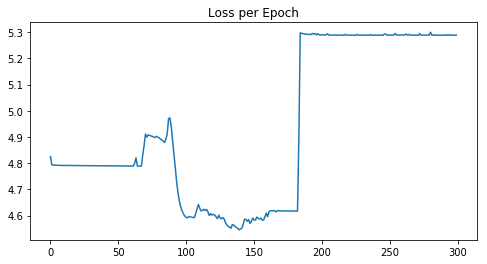

In [78]:
plt.figure(figsize=[8,4])
plt.plot(net.history.history['loss'])
plt.title("Loss per Epoch")


In [79]:
final = net.get_weights()
net.load_weights('bestRun.h5')
# net.set_weights(final)
tree = net.predict(trainX).mean(0)

seqs = []
for species in [speciesList[i] for i in mySpecies]:
    seq = ''
    seq = seq + ''.join(gene[species])
    seqs.append(SeqRecord(Seq(seq), name=nmap[species], id=nmap[species]))
    
    
msa = MultipleSeqAlignment(seqs)
ps = ParsimonyScorer()
searcher = NNITreeSearcher(ps)
constructor = ParsimonyTreeConstructor(searcher)
pars_tree = constructor.build_tree(msa)


def matrixToTree(topArgs, root):
#     nodes = len(tree)
    nSpecies = topArgs.shape[1]+1
    if root < nSpecies: return nmap[speciesList[mySpecies[root]]]
    return (matrixToTree(topArgs, topArgs[0,root-nSpecies]),
            matrixToTree(topArgs, topArgs[1,root-nSpecies]))

newick = matrixToTree(tree.argsort(0)[-2:][::-1], tree.shape[0]-1)
handle = StringIO(str(newick))





In [80]:

neuralNetTree = Bio.Phylo.read(handle, "newick")
neuralNetTree.rooted=True


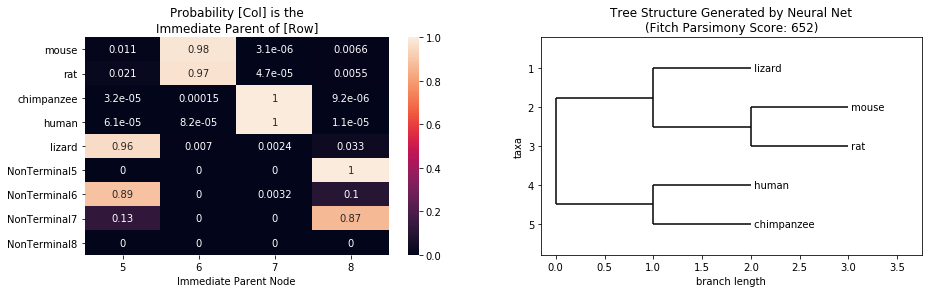

In [81]:
plt.figure(figsize=[15,4])

ax1 = plt.subplot(1,2,1)
sns.heatmap(tree, vmin=0.0, vmax=1.0, annot=True)
plt.xticks([j +.5 for j in range(tree.shape[1])], [str(i) for i in range(tree.shape[1]+1,(2*tree.shape[1])+1)])
plt.yticks([j +.5 for j in range(tree.shape[0])], [nmap[speciesList[i]] for i in mySpecies] + ['NonTerminal'+str(i) for i in range(nSpecies,tree.shape[0])],
          rotation=0)
plt.title('Probability [Col] is the\nImmediate Parent of [Row]')
plt.xlabel('Immediate Parent Node')
ax2 = plt.subplot(1,2,2)
nn_score = ps.get_score(neuralNetTree, msa)
plt.title('Tree Structure Generated by Neural Net\n(Fitch Parsimony Score: '+str(nn_score)+')')
Bio.Phylo.draw(neuralNetTree, axes = ax2)


plt.tight_layout()

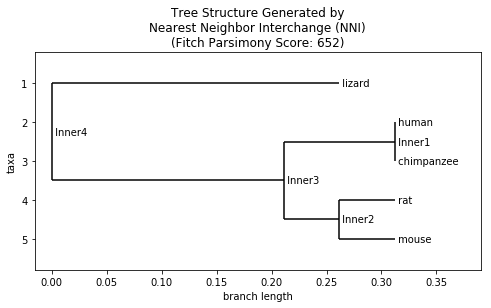

In [82]:
plt.figure(figsize=[8,4])
bioPython_score = ps.get_score(pars_tree, msa)
plt.title('Tree Structure Generated by\nNearest Neighbor Interchange (NNI)\n(Fitch Parsimony Score: '+str(bioPython_score)+')')
Bio.Phylo.draw(pars_tree, axes=plt.gca())


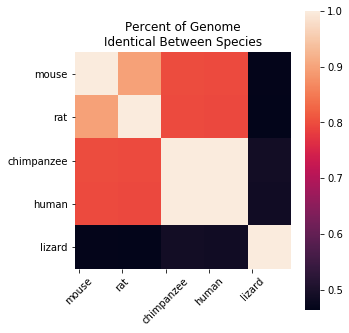

In [83]:
plt.figure(figsize=[nSpecies,nSpecies])
tx = np.matmul(np.transpose(trainX,[0,2,1]), trainX).mean(0)
sns.heatmap(tx, square=True)
plt.xticks([j +.1 for j in range(nSpecies)], [nmap[speciesList[i]] for i in mySpecies], rotation=45)
plt.yticks([j +.5 for j in range(nSpecies)], [nmap[speciesList[i]] for i in mySpecies],rotation=0)
plt.title("Percent of Genome\nIdentical Between Species")
plt.tight_layout()